# 4. 모델 훈련

**기본설정**

파이썬 3.7 이상을 요구한다.

In [1]:
import sys

assert sys.version_info >= (3, 7)

사이킷런 1.0.1 이상을 요구한다.

In [2]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

다음은 이미지에 포함된 폰트 크기를 설정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 4.1. 선형 회귀

선형 회귀 모델을 구현하는 과정을 살펴본다.

아래 코드는 선형 회귀 모델 훈련에 사용될 데이터 100개를 무작위로 생성한다. 
`y = 4 + 3 * X ` 1차 함수를 모델로 하는 데이터이며
약간의 잡음이 추가된다. 

In [4]:
import numpy as np

np.random.seed(42)

# 데이터셋 크기
m = 100
# 입력 데이터셋: 0에서 2 사이의 임의의 값 100개.
X = 2 * np.random.rand(m, 1)
# 타깃: y = 4 + 3*X 함수를 이용한 타깃값 생성. 잡음 추가.
y = 4 + 3 * X + np.random.randn(m, 1)

데이터를 산점도로 그리면 잡음 때문에 일직선이 아니지만
그래도 꽤 선형적으로 퍼져 있는 데이터 분포를 확인할 수 있다.

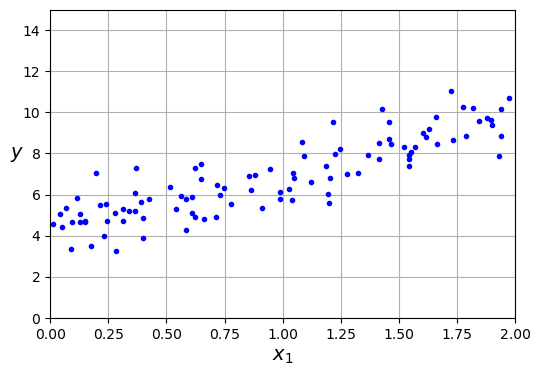

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

### `LinearRegression` 모델

사이킷런의 `LinearRegression` 모델은 무어-펜로즈 유사 역행렬을 이용하여
선형 회귀 모델이 사용하는 최적의 절편과 기울기를 계산한다.

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# 절편과 기울기
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

예측은 `predict()` 메서드를 이용한다. 
아래 그래프에서 사용된 빨강 직선을 그리기 위해 필요하다.
이유는 앞서 찾아낸 최적의 모델은 직선으로 그릴 수 있으며
직선을 그릴 때 두 점이 필요하기 때문이다.

In [7]:
X_new = np.array([[0], [2]])
y_predict = lin_reg.predict(X_new)
y_predict

array([[4.21509616],
       [9.75532293]])

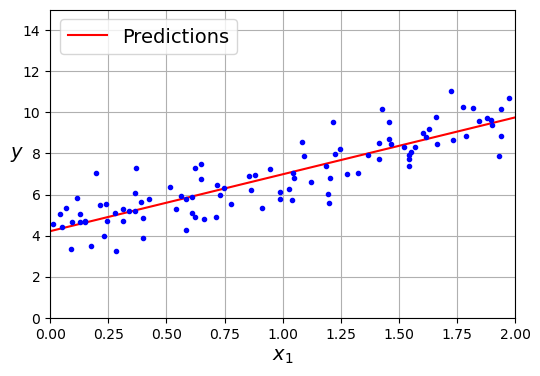

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

# 빨간 직선: (0, 4.21509616)과 (2, 9.75532293) 두 점을 지나는 직선
plt.plot(X_new, y_predict, "r-", label="Predictions")
# 데이터셋 산점도
plt.plot(X, y, "b.")

# 그래프 추가 설정
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15]) # x-축 범위: 0~2, y-축 범휘: 0~15
plt.grid()
plt.legend(loc="upper left")

plt.show()

## 4.2. 경사 하강법

## 4.3. 비선형 데이터 학습: 다항 회귀

비선형 데이터를 학습하는 선형 회귀 모델을 훈련시기키 위해 다항 회귀를 적용한다.

다항 회귀 모델을 구성하는 과정을 설명하기 위해 2차 함수를 따르는 데이터셋을 생성한다.

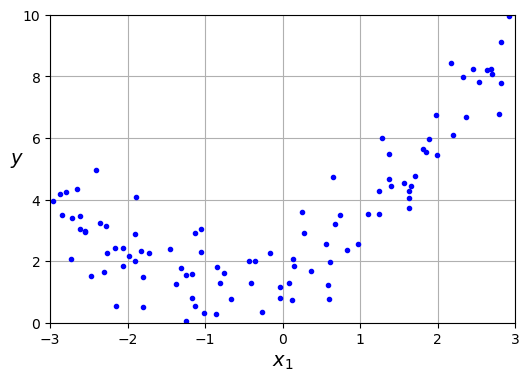

In [9]:
# 데이터셋 생성

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3                 # 입력값: -3에서 3 사이의 임의의 값 100개
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1) # 타깃: 2차 함수 활용. 잡음 추가.

# 데이터셋 산점도
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

**사이킷런의 `PolynomialFeatures` 변환기**

아래 코드는 2차 항에 해당하는 특성을 새로 추가한다.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)      # 2차 특성 추가

실행 결과 $x_1^2$ 에 해당하는 특성 $x_2$ 가 추가된 것을 확인할 수 있다.

- 원조 데이터셋의 0번 샘플: 하나의 특성 $x_1$만 사용

In [11]:
X[0]  # [x1]

array([-0.75275929])

- 변환된 데이터셋의 0번 샘플: 두 개의 특성 $x_1$, $x_1^2$ 사용

In [12]:
X_poly[0]  # [x1, x2]

array([-0.75275929,  0.56664654])

이제 선형 회귀 모델을 적용하면 적절한 절편 $\theta_0$ 과 가중치$\theta_1$ 과 $\theta_2$ 를 얻는다.

| 인스턴스 변수 | 저장된 값 | 의미 |
| :--- | :---: | :---: |
| `intercept_` | $\theta_0$ | 편향 |
| `coef_` | [ $\theta_1$, $\theta_2$ ] | 가중치 |

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

모델을 시각화하면 훈련 데이터셋을 잘 반영하는 2차 함수의 그래프가 그려진다.

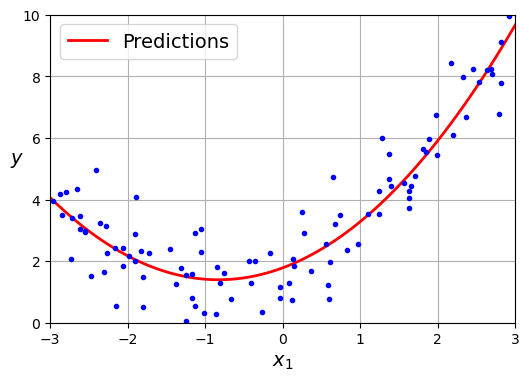

In [14]:
plt.figure(figsize=(6, 4))

# 최적의 2차 함수 그래프(빨강 곡선)
X_new = np.linspace(-3, 3, 100).reshape(100, 1)  # x1 값: -3에서 3 사이를 100등분해서 얻어지는 값.
X_new_poly = poly_features.transform(X_new)      # x1**2 특성 추가
y_new = lin_reg.predict(X_new_poly)              # 예측 타깃값
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")

# 데이터셋 X 산점도(파랑 점)
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")  # 범례 위치
plt.axis([-3, 3, 0, 10])      # x-축: -3부터 3까지, y-축: 0부터 10까지
plt.grid()                    # 격자 무늬 추가
plt.show()

## 4.4. 학습 곡선

아래 그림은 1차, 2차, 300차 다항 회귀의 결과를 보여준다.

- 1차 다항 회귀(선형 회귀): 과소 적합 모델
- 2차 다향 회귀: 최적 모델
- 100차 다항 회귀: 과대 적합 모델

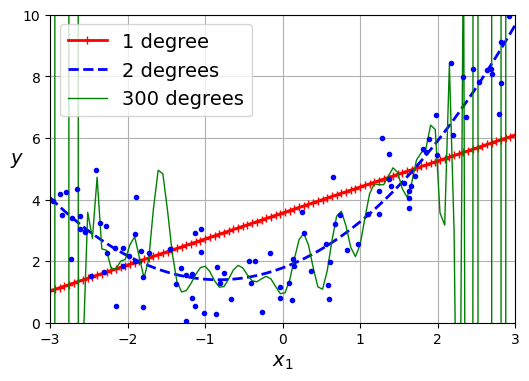

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

# 1차, 2차, 300차 다항 회귀 모델 계산
# style: 빨강 직선(-+ 기호), 파랑 파선(-- 기호), 초록 실선 등 지정
# width: 그래프 선 두께 지정
# degree; 1차, 2차, 100차 지정
for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    # 고차 항 추가
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # 변환 파이프라인
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    
    # 선형 회귀 모델 계산
    polynomial_regression.fit(X, y)
    
    # 모델별 예측값 
    y_newbig = polynomial_regression.predict(X_new)
    
    # 그래프 그리기
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

# 데이터셋 산점도
plt.plot(X, y, "b.", linewidth=3)

plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

### 과소 적합 모델의 학습 곡선 특징

학습 곡선은 훈련셋과 검증 세트에 대한 모델 성능을 비교하는 그래프이며, 학습 곡선의 모양에 따라 과소 적합 또는 과대 적합 여부를 판정할 수 있다.

`learning_curve()` 함수는 학습 곡선를 그리는 데에 필요한
훈련셋의 크기, 훈련 점수, 검증 점수를 계산한다. 

- `train_sizes`: 훈련셋 크기(전체의 1명부터 100명 사이의 구간)를 40등분한 값들의 리스트, 최소 1, 최대 80. 이유는 5겹 교차 검증을 사용하기에 1/5, 즉 20%는 검증셋으로 사용됨. 따라서 최대 훈련셋의 크기는 80.
- `train_scores`: 지정된 훈련셋 마다 실행된 5겹 교차 검증을 통해 생성된 훈련 점수들로 구성된 (40, 5) 모양의 2차원 어레이. 
- `valid_scores`: 지정된 훈련셋 마다 실행된 5겹 교차 검증을 통해 생성된 검증 점수들로 구성된 (40, 5) 모양의 2차원 어레이. 

아래 코드는 2차 함수의 분포를 따르는 데이터셋에 선형 회귀를 바로 적용하는 경우의 학습 곡선을 그릴 때 필요한 데이터를 생성한다.

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, 
    train_sizes=np.linspace(0.01, 1.0, 40),  # 훈련셋 크기: 1% 에서 출발하여 2.5% 씩 증가
    cv=5,                                    # 5-겹 교차 검증 진행
    scoring="neg_root_mean_squared_error")   # 효용 함수: RMSE의 음숫값

train_errors = -train_scores.mean(axis=1)   # 행별 훈련 점수들의 평균값들의 1차원 어레이. 양수로 다시 변환.
valid_errors = -valid_scores.mean(axis=1)   # 행별 검증 점수들의 평균값들의 1차원 어레이 양수로 다시 변환.

In [17]:
train_sizes.shape

(40,)

In [18]:
train_scores.shape

(40, 5)

In [19]:
valid_scores.shape

(40, 5)

- 학습 곡선 그리기

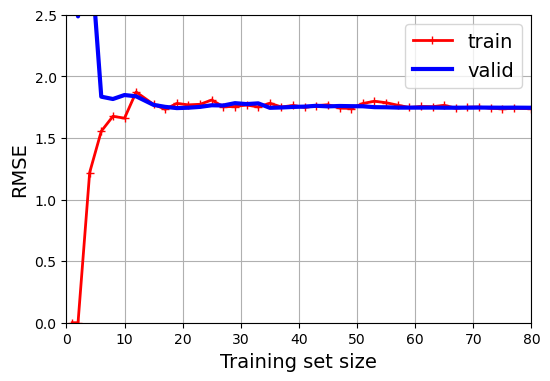

In [20]:
plt.figure(figsize=(6, 4))

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train") # 훈련셋 크기 변화에 따른 훈련 점수 변화 그래프
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")  # 훈련셋 크기 변화에 따른 검증 점수 변화 그래프

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])

plt.show()

**과대 적합 모델의 학습 곡선 특징**

과대 적합 모델은 다른 모양의 학습 곡선을 생성한다. 
아래 코드는 주어진 2차 함수 모델의 데이터셋에 
10차 다항 회귀를 사용하면 전형적인 과대 적합 현상이 발생함을 보여준다.

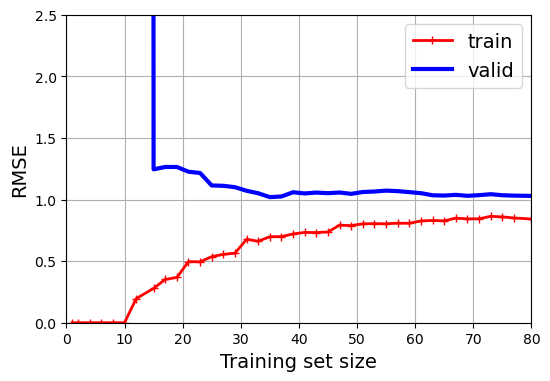

In [21]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression() )

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, 
    train_sizes=np.linspace(0.01, 1.0, 40), 
    cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

## 4.5 규제 사용 선형 모델

확률적 경사하강법을 사용하는 `SGDRegressor` 모델이 세 종류의 규제를 지원한다.


In [22]:
from sklearn.linear_model import SGDRegressor

### 릿지 회귀

- `SGDRegressor` 클래스
    - `penalty='l2'`: 릿지 규제 지정

In [23]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([4.7852203])

- `Ridge` 클래스 모델
    - `solver="sag"`: 확률적 경사 하강법 실행 알고리즘
    - `alpha` 값을 `SGDRegressor`의 경우보다 보다 `len(X)` 배 만큼 큰 값을 사용해야 함.
    - 릿지 규제를 적용한 `SGDRegressor`모델과 가장 유사

In [24]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1 * X.shape[0], solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.75205201]])

### 라쏘 회귀

- `SGDRegressor` 클래스
    - `penalty='l1'`: 라쏘 규제 지정

In [25]:
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([4.77557733])

- `Lasso` 클래스 모델

In [26]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

### 엘라스티 넷 회귀

- `SGDRegressor` 클래스
    - `penalty='elasticnet'`:  엘라스틱 넷 회귀 지정
    - `l1_ratio=0.5`: 릿지 규제와 라쏘 규제 사용 비율

In [27]:
sgd_reg = SGDRegressor(penalty="elasticnet", alpha=0.1, tol=None, 
                       l1_ratio=0.5,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([4.78047395])

- `ElasticNet` 클래스 모델

In [28]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

### 조기 종료

아래 코드는 `SGDRegressor` 모델에 조기 종료 기법을 이용할 때
규제 정도에 따라 조기 종료가 다르게 발생함을 보여준다.

- 훈련셋 준비: 2차 다항 함수의 분포를 따르는 100개의 샘플로 구성된 데이터셋 생성

In [29]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

- `SGDRegressor` 모델
    - 여러 `alpha` 값에 반복문을 실행하면서 다양한 규제 적용 모델 확인
    - `penalty='elasticnet'`: 엘라스틱 넷 회귀 적용
    - `l1_ratio=0.5`: 라쏘 규제 비율
    - `eta0=0.002`: 학습률
    - `early_stopping=True`: 조기 종료 실행. 훈련셋의 일부를 검증셋으로 활용.
    - `max_iter=1000`: 최대 훈련 에포크
    - `tol=1e-3`: 훈련 점수 또는 검증 점수가 지정된 값 이하로 최대 `n_iter_no_change` 에포크 동안 변하지 않으면 조기 종료 실행
    - `n_iter_no_change=5`: 훈련 점수 또는 검증 점수가 지정된 에포크 동안 얼마나 변하는지 확인

- 전처리 파이프라인
    - 90차 다항 회귀 변환
    - 표준화 스케일링

- `n_iter_` 속성 변수: `SGDRegressor` 모델의 훈련이 조기종료 될 때까지 실행된 에포크 수 저장

In [30]:
for alpha in [0, 0.01, 0.1, 0.13, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 5, 10]:
    # 사용할 모델
    sgd_reg = SGDRegressor(penalty='elasticnet', alpha=alpha, l1_ratio=0.5,
                            eta0=0.002, random_state=42,
                            early_stopping=True,
                            max_iter=1000, tol=1e-3, n_iter_no_change=5)
    
    # 전처리 파이프라인 포함 모델 지정
    sgd = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                                  StandardScaler(),
                                  sgd_reg)
    # 모델 훈련
    sgd.fit(X, y.ravel())

    # 실제 훈련된 에포크 수 출력
    print(f"alpha={alpha:5.2f}일 때 실제 사용된 에포크: {sgd_reg.n_iter_:2d}")

alpha= 0.00일 때 실제 사용된 에포크:  6
alpha= 0.01일 때 실제 사용된 에포크:  6
alpha= 0.10일 때 실제 사용된 에포크:  6
alpha= 0.13일 때 실제 사용된 에포크: 137
alpha= 0.15일 때 실제 사용된 에포크: 137
alpha= 0.20일 때 실제 사용된 에포크: 131
alpha= 0.30일 때 실제 사용된 에포크: 122
alpha= 0.40일 때 실제 사용된 에포크: 112
alpha= 0.50일 때 실제 사용된 에포크: 104
alpha= 1.00일 때 실제 사용된 에포크: 82
alpha= 5.00일 때 실제 사용된 에포크: 113
alpha=10.00일 때 실제 사용된 에포크: 113


- 결론: `alpha=0.15`일 때 조기 종료가 가장 늦게 일어나며, 이런 모델의 일반화 성능이 가장 좋다.

## 4.6 로지스틱 회귀

### 붓꽃 데이터셋

`load_iris()` 함수가 붓꽃 데이터셋을 불러온다.

In [31]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

불러온 자료형는 사전(`dict`)과 유사한 `Bunch` 자료형이며 사이킷런 라이브러리에서 제공한다.

- `Bunch` 자료형은 키를 사용한 인덱싱을 마치 클래스의 속성을 확인하는 방식으로 다룰 수 있음
- 예제: `iris['data']` 대시 `iris.data` 사용 가능

In [32]:
type(iris)

sklearn.utils._bunch.Bunch

포함된 키(key)는 다음과 같다.

In [33]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

- `DESCR` 키: 붓꽃 데이터셋에 대한 설명

In [34]:
print(iris.DESCR)  # iris['DESCR']

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

- `data` 키: 4 개의 특성으로 구성된 데이터프레임. 샘플은 총 150개.
    - `sepan length (cm)`: 꽃받침 길이
    - `sepan width (cm)`: 꽃받침 너비
    - `petal length (cm)`: 꽃잎 길이
    - `petal width (cm)`: 꽃잎 너비
- 처음 5개 데이터는 다음과 같음

In [35]:
iris.data.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


- `target` 키: 정수로 구성된 레이블셋. 1차원 어레이.

In [36]:
iris.target.head(5) # 세토사 품종 5개

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

- `target_names` 키: 레이블 실제 이름
    - `'setosa'`: 세토사. 레이블 0에 해당.
    - `'versicolor'`: 버시컬러. 레이블 1에 해당.
    - `'virginica'`: 버지니카. 레이블 2에 해당.

In [37]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

### 결정 경계

**버지니카 품종 감지기: 꽃잎 너비 특성 활용**

- 꽃잎의 너비 특성 하나만 이용하여 붓꽃의 품종 판별

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

- 결정 경계 확인: 꽃잎 너비 1.65 기준으로 그 이상이면 버지니카 양성으로 판정

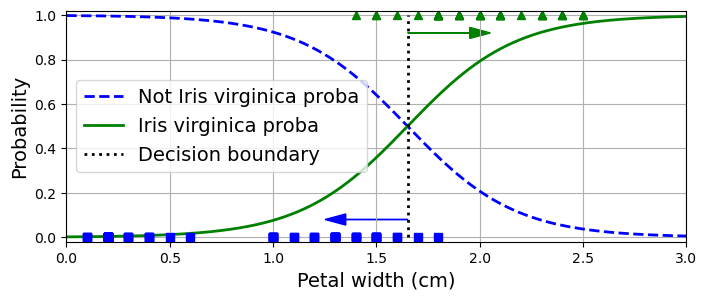

In [39]:
# 두 곡선 그래프에 필요한 x-좌표 어레이
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) # 2차원 어레이로 변환
# y-좌표: 양성 예측 확률값
y_proba = log_reg.predict_proba(X_new)
# 결정 경계 확인: 양성 예측 확률이 0.5인 지점(꽃잎 너비 기준)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

# 그래프 그리기
plt.figure(figsize=(8, 3))

# 파랑 파선
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
# 초록 실선
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
# 결정 경계: 검정 수직 점선
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# 화살표 그리기
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")

# 하단 파랑 네모: 일부 잘못 분류된 샘플 확인 가능
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")

# 상단 초록 세모: 일부 잘못 분류된 샘플 확인 가능
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()

plt.show()

결정 경계는 약 1.65이다.

In [40]:
decision_boundary

1.6516516516516517

**버지니카 품종 감지기: 꽃잎 길이와 너비 특성 활용**

꽃잎의 길이와 너비 두 특성을 이용하여 붓꽃의 품종을 판별한다.

- 로지스틱 회귀 모델 훈련
    - `LogisticRegression` 클래스의 `multi_class='ovr'` 가 이진 분류의 경우 자동으로 사용됨.

In [41]:
# 두 특성만 사용하는 입력 데이터셋 준비
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 로지스틱 회귀 모델 준비: `C`는 규제 강도. 기본값은 1. 작은 값일 수록 큰 규제.
log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)


LogisticRegression(C=2, random_state=42)

- 결정 경계

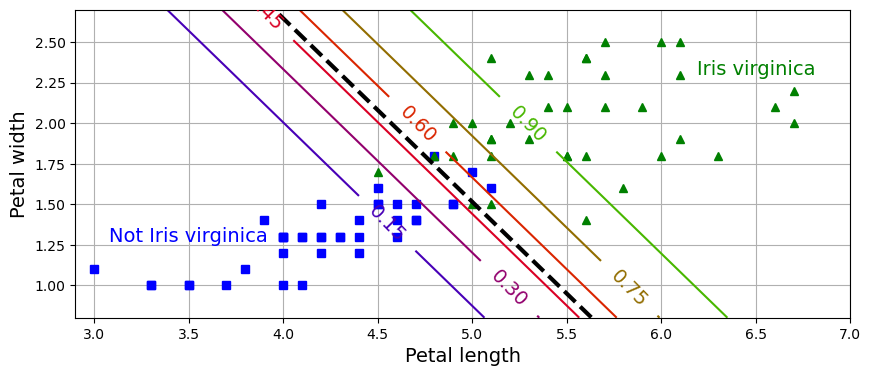

In [42]:
# 직선을 그리기 위한 데이터셋
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # x-좌표와 y-좌표를 묶어 2개의 특성으로 지정.
y_proba = log_reg.predict_proba(X_new) # 예측 확률: 음성 확률과 양성 확률의 튜플

# 버지니카로 판정될 양성 확률을 등고선 그릴 때 사용
zz = y_proba[:, 1].reshape(x0.shape)   # 양성 예측 확률만 사용

# 결정 경계: theta0 + x1 * theta1 + x2 * theta2 = 0 을 만족시키는 직선
left_right = np.array([2.9, 7]) # 직선상에 위치한 두 점의 x-좌표
# 두 점의 y-좌표 계산
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

# 그래프 그리기
plt.figure(figsize=(10, 4))

# 산점도: 파랑 네모. 버지니카가 아닌 샘플
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
# 산점도: 초록 세모. 버지니카인 샘플
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")

# 등고선: 버지니카일 확률 기준
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1) # 양성 확률 함께 표시

# 결정 경계 그리기
plt.plot(left_right, boundary, "k--", linewidth=3)

# 기타 문장 표시
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")

# 축 레이블 표시
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

### 소프트맥스 회귀

**붓꽃 데이터 다중 클래스 분류**

꽃잎의 길이와 너비 두 특성을 이용하여 세토사, 버시컬러, 버지니카 클래스 중 하나를 선택하는 모델을 훈련시킨다.

- 소프트맥스 모델 훈련
    - `LogisticRegression` 모델을 다중 클래스 분류 모델로 훈련시키면 `multi_class='multinomial'` 옵션이 
        자동 지정되어 소프트맥스 회귀를 적용함
    - `C=30`: 약한 규제

In [43]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

- 결정 경계
    - 바탕화면 색: 색상의 헥사(Hex) 값 활용
    - 참고: [W3 Schools: Color converter](https://www.w3schools.com/colors/colors_converter.asp)

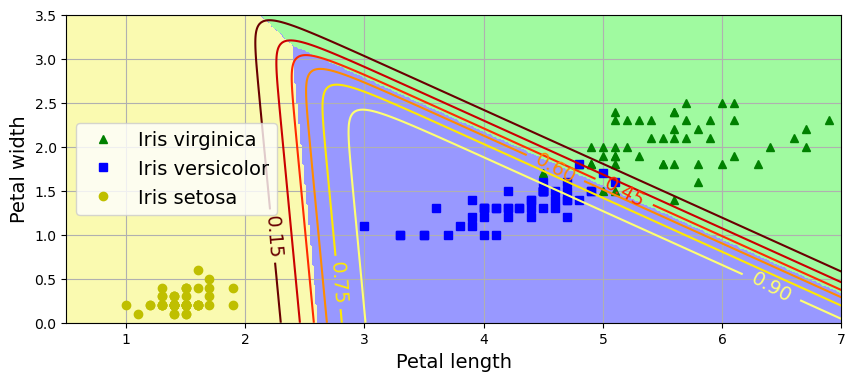

In [44]:
# 레이블 별 바탕화면 색 지정
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"]) # 노랑, 파랑, 초록

# 바탕화면을 그리기위한 좌표
# x-좌표
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

# y-좌표
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

# `contour` 용 y-좌표: 버시컬러 확률 기준
zz1 = y_proba[:, 1].reshape(x0.shape)
# `contourf` 용 y-좌표: 예측값 기준
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

# 등고선 그리기: 색으로 구분. 예측 확률 기준
plt.contourf(x0, x1, zz, cmap=custom_cmap)
# 등고선 그리기: 버시컬러 품종일 가능성 확률 기준
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
plt.show()

**로지스틱 회귀와 일대다 분식**

아래 코드는 로지스틱 회귀에 일대다 방식을 적용하여 다중 클래스 분류를 진행한 결과를 보여준다.
결론적으로 좀 다르게 작동하며 소프트맥스 회귀보다 성능이 좋다고 말하기 어렵다.

- `LogisticRegression` 모델의 `multi_class='ovr'` 옵션 사용

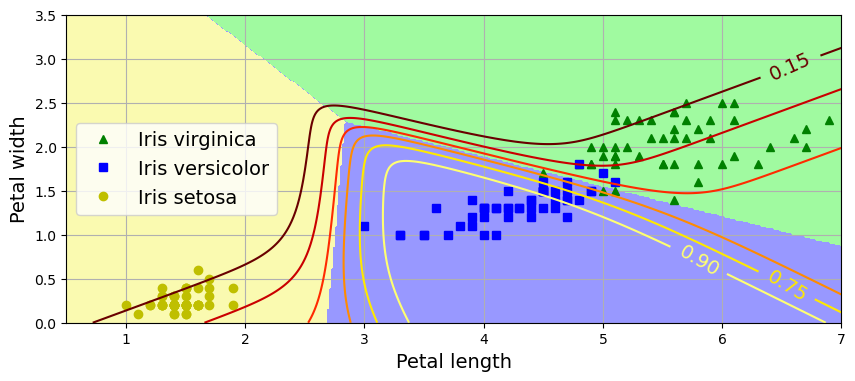

In [45]:
logistic_reg_ovr = LogisticRegression(C=30, multi_class='ovr', random_state=42)
logistic_reg_ovr.fit(X_train, y_train)

# y-좌표
y_proba = logistic_reg_ovr.predict_proba(X_new)
y_predict = logistic_reg_ovr.predict(X_new)

# `contour` 용 y-좌표: 버시컬러 확률 기준
zz1 = y_proba[:, 1].reshape(x0.shape)
# `contourf` 용 y-좌표: 예측값 기준
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

# 등고선 그리기: 색으로 구분. 예측 확률 기준
plt.contourf(x0, x1, zz, cmap=custom_cmap)
# 등고선 그리기: 버시컬러 품종일 가능성 확률 기준
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
plt.show()

## 연습 문제

## 1. to 11.

1. If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.
2. If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.
3. Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex. _Convex_ means that if you draw a straight line between any two points on the curve, the line never crosses the curve.
4. If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.
5. If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.
6. Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.
7. Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.
8. If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.
9. If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter _α_.
10. Let's see:
  * A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
  * Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
  * Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12. 경사 하강법 훈련의 조기 종료를 지원하는 소프트맥스 회귀 구현

붓꽃 데이터셋을 대상으로 다중 클래스 분류를 진행하는 모델을 소프트맥스 회귀를 이용하여 구현한다.
단, 넘파이 모듈만을 이용하며 조기 종료 기능을 사용한다.
또한 사이킷런 라이브러리는 전혀 사용하지 않는다.

In [1]:
import sklearn
import numpy as np

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 붓꽃 데이터셋 준비

**붓꽃 데이터셋 적재**

In [3]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

훈련셋과 타깃셋을 지정한다.
훈련셋 샘플은 꽃잎의 길이와 너비 2개 특성만 사용한다.

In [4]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

**입력 데이터셋 변환: 항목 1 추가**

모든 훈련 샘플에 1을 첫째 특성으로 추가한다.
이유는 예측값을 계산할 때 다음과 같이 편향(bias)를 고려해서 계산이 사용되기 때문이다.

$$
1\cdot \theta_0 + x_1 \cdot \theta_1 + \cdots + x_n \cdot \theta_{n}
= [1, x_1, \dots, x_n]\, 
\begin{bmatrix}
\theta_0\\
\theta_1 \\
\vdots \\
\theta_n
\end{bmatrix}
$$

사이킷런의 `add_dummy_feature()` 함수를 이용하면 되지만 여기서는 경사하강법을 보다 깊이 이해하기 위해 직접 구현한다.

- `np_c[]`: 어레이를 좌우로 이어붙이기
- `np.ones()`: 1로 구성된 어레이 생성. 인자는 생성되는 어레이 모양(shape)

In [5]:
X_with_bias = np.c_[np.ones(len(X)), X]

변환된 입력 데이터셋은 다음과 같다.

In [6]:
X_with_bias[:5]

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2]])

반면에 기존의 입력 데이터셋 `X`는 다음과 같다.

In [7]:
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

**훈련셋, 검증셋, 테스트셋 구분**

사이킷런의 `train_test_split()` 함수를 이용하면 간단하지면 역시나 직접 구현한다.

- 훈련셋, 검증셋, 테스트셋 비율은 6:2:2

In [8]:
test_ratio = 0.2              # 테스트셋 비율
validation_ratio = 0.2        # 검증셋 비율

total_size = len(X_with_bias) # 150. 전체 입력 데이터셋 크기

test_size = int(total_size * test_ratio)              # 테스트셋 크기
validation_size = int(total_size * validation_ratio)  # 검증셋 크기
train_size = total_size - test_size - validation_size # 훈련셋 크기

3개의 데이터셋으로 분류하기 전에 전체 입력 데이터셋을 무작위로 섞는다.

- 0부터 149의 인덱스를 무작위로 섞기

In [9]:
np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

인덱스 순서가 섞였다.

In [10]:
rnd_indices

array([ 73,  18, 118,  78,  76,  31,  64, 141,  68,  82, 110,  12,  36,
         9,  19,  56, 104,  69,  55, 132,  29, 127,  26, 128, 131, 145,
       108, 143,  45,  30,  22,  15,  65,  11,  42, 146,  51,  27,   4,
        32, 142,  85,  86,  16,  10,  81, 133, 137,  75, 109,  96, 105,
        66,   0, 122,  67,  28,  40,  44,  60, 123,  24,  25,  23,  94,
        39,  95, 117,  47,  97, 113,  33, 138, 101,  62,  84, 148,  53,
         5,  93, 111,  49,  35,  80,  77,  34, 114,   7,  43,  70,  98,
       120,  83, 134, 135,  89,   8,  13, 119, 125,   3,  17,  38,  72,
       136,   6, 112, 100,   2,  63,  54, 126,  50, 115,  46, 139,  61,
       147,  79,  59,  91,  41,  58,  90,  48,  88, 107, 124,  21,  57,
       144, 129,  37, 140,   1,  52, 130, 103,  99, 116,  87,  74, 121,
       149,  20,  71, 106,  14,  92, 102])

무작위로 섞인 인덱스를 이용하여 지정된 비율로 훈련셋, 검증셋, 테스트셋으로 분리한다.

In [11]:
# 훈련셋
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

# 검증셋
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

# 테스트셋
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

### 데이터셋 전처리

**타깃 원-핫 인코딩**

레이블은 0, 1, 2 중에 하나를 사용하는 정수로 지정되어 있다.
그런데 샘플의 확률 예측값 $\hat p$는 각각의 클래스(품성)에 속할 확률로 구성된
길이가 3인 1차원 어레로 계산된다.
예를 들어 세토사 품종이라고 예측되는 샘플에 대한 확률 예측값은 아래와 같다.

```
[0.9, 0.01, 0.09]
```

즉, 0번 인덱스의 값이 가장 크고, 나머지는 거의 0에 가깝게 계산돼야 한다.

따라서 확률 예측값과 타깃(레이블) 사이의 오차를 이용하여 비용함수를 계산하려면
레이블을 원-핫 인코딩해서 모양을 맞춘다.
참고로 원-핫 인코딩은 레이블로 지정된 값의 인덱스에만 1, 나머지는 0으로 채운 어레이를 생성한다.

아래 `to_one_hot()` 함수가 원-핫 인코딩을 실행한다.

- `np.diag(np.ones(n))`: 대각선상은 1, 나머지 항목은 0으로 채워진 (n, n) 모양의 2차원 어레이 생성. 즉, 단위 행렬 생성.
- `n`은 타깃 클래스의 개수. 예를 들어 붓꽃 데이터셋의 경우는 3을 가리킴.
- 생성된 단위 행렬에 타깃 클래스들로 이뤄진 정수 리스트를 이용하여 팬시 인덱싱을 진행하면 원-핫 인코딩된 어레이가 생성됨.
- 팬시 인덱싱; `a[[1, 3, 2, 3, 2, 2, 1]]`는 `a[1]`, `a[3]`, `a[2]`, `a[3]`, `a[2]`, `a[2]`, `a[1]` 로 구성된 어레이 생성.

In [12]:
def to_one_hot(y):
    """
    y는 타깃 클래스로 구성된 1차원 어레이
    """
    n = y.max() + 1         # y 항목의 최대값 + 1
    a = np.diag(np.ones(n)) # (n, n) 모양의 단위 행렬
    return a[y]             # 팬시 인덱싱

처음 10개의 레이블에 대해 원-핫 인코딩을 실행하면 다음과 같다.

- 처음 10개의 레이블

In [13]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

- 원-핫 인코딩된 처음 10개의 레이블

In [14]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

잘 작동한다.
이제 모든 레이블을 원-핫 인코딩한다.

In [15]:
Y_train_one_hot = to_one_hot(y_train) # 훈련셋 레이블
Y_valid_one_hot = to_one_hot(y_valid) # 검증셋 레이블
Y_test_one_hot = to_one_hot(y_test)   # 테스트셋 레이블

예를 들어 변환된 훈련셋에 포함된 90개의 레이블은 3개의 특성을 갖는다.

- 90은 전체 데이터셋 크기인 150의 60%.

In [16]:
Y_train_one_hot.shape

(90, 3)

**특성 표준화**

편향값 1을 제외한 모든 특성에 대해 표준화를 진행한다.
이때 사용되는 평균값(mean)과 표준편차(std)는 훈련셋만 이용하여 구하며,
이를 이용하여 훈련셋, 검증셋, 테스트셋의 표준화를 함께 진행한다.

주의사항: 검증셋과 테스트셋의 평균값과 표준편차는 이용하지 않는다.

In [17]:
# 훈련셋의 평균값과 표준편차(편향값 제외). 특성별 계산.
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)

# 표준화 진행. 편향값 제외.
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

### 소프트맥스 회귀 확률 예측값

**소프트맥스 점수**

입력 샘플 $\mathbf x = [x_1, \dots, x_n]$가 주어졌을 때 각각의 분류 클래스 $k$ 에 대해 **소프트맥스 점수** $s_k(\mathbf x)$를
선형 회귀 방식으로 계산한다.

$$
s_k(\mathbf{x}) = \theta_0^{(k)} + \theta_1^{(k)} x_1 + \cdots + \theta_n^{(k)} x_n
= [1, x_1, \dots, x_n]\, 
\begin{bmatrix}
\theta_0^{(k)}\\
\theta_1^{(k)} \\
\vdots \\
\theta_n^{(k)}
\end{bmatrix}
$$    

위 식에서 $\theta_i^{(k)}$ 는 $i$ 번째 특성에 대한 파라미터이며 $k$ 클래스와 관련된 소프트맥스 점수 계산에 사용된다.
따라서 총 $K$ 개의 타깃 클래스로 분류하는 모델은 훈련 중에 총 $(n+1)\cdot K$ 개의 파라미터를 학습한다.

예를 들어, 붓꽃 데이터셋에 포함된 꽃잎의 길이와 너비 $n = 2$ 개의 특성을 이용하여 $K=3$ 개의 품종으로 분류하는
소프트맥스 회귀 모델을 훈련시키려면 3 $\times$ 3 = 9개의 파라미터가 훈련된다.
9 개의 파라미터로 구성된 파라미터 행렬은 아래와 같다.

$$
\Theta = 
\begin{bmatrix}
\theta_0^{(0)} & \theta_0^{(1)} & \theta_0^{(2)} \\
\theta_1^{(0)} & \theta_1^{(1)} & \theta_1^{(2)} \\
\theta_2^{(0)} & \theta_2^{(1)} & \theta_2^{(2)} 
\end{bmatrix}
$$

반면에 꽃잎 길이와 너비 두 개의 특성과 추가된 편향으로 구성된 훈련셋 `X_train`은 다음과 같은 형식이다.
각 행이 하나의 샘플을 가리키며, 여기서는 훈련셋에 90개의 샘플이 포함되어 있는 것을 표현한다.
훈련셋의 크기가 90임에 주의한다.

$$
\mathbf{X}_{train} = 
\begin{bmatrix}
1 & x_1^{(0)} & x_2^{(0)} \\
1 & x_1^{(1)} & x_2^{(1)} \\
 & \vdots & \\
1 & x_1^{(89)} & x_2^{(89)} 
\end{bmatrix}
$$

이제 모든 훈련 샘플에 대한 소프트맥스 점수를 일시에 다음과 같이 행렬곱으로 계산할 수 있다.

$$
\mathbf{X}_{train} \,\, \Theta
= 
\begin{bmatrix}
1 & x_1^{(0)} & x_2^{(0)} \\
1 & x_1^{(1)} & x_2^{(1)} \\
 & \vdots & \\
1 & x_1^{(89)} & x_2^{(89)} 
\end{bmatrix}
\,\,
\begin{bmatrix}
\theta_0^{(0)} & \theta_0^{(1)} & \theta_0^{(2)} \\
\theta_1^{(0)} & \theta_1^{(1)} & \theta_1^{(2)} \\
\theta_2^{(0)} & \theta_2^{(1)} & \theta_2^{(2)} 
\end{bmatrix}
=
\begin{bmatrix}
s_0(\mathbf{x}^{(0)}) & s_1(\mathbf{x}^{(0)}) & s_2(\mathbf{x}^{(0)}) \\
s_0(\mathbf{x}^{(1)}) & s_1(\mathbf{x}^{(1)}) & s_2(\mathbf{x}^{(1)}) \\
& \vdots & \\
s_0(\mathbf{x}^{(89)}) & s_1(\mathbf{x}^{(89)}) & s_2(\mathbf{x}^{(89)})
\end{bmatrix}
$$

**소프트맥스 함수**

**소프트맥스 함수** $\sigma()$는 각 클래스에 속할 확률 $\hat p_k$를 계산한다.
인자는 소프트맥스 점수로 구성된 벡터 $\mathbf{s}(\mathbf{x}) = [s_0(\mathbf{x}), \dots, s_{K-1}(\mathbf{x})]$ 이다.

$$
\hat p_k 
= \sigma(\mathbf{s}(\mathbf{x}))[k]
= \frac{\exp(s_k(\mathbf x))}{\sum\limits_{j=0}^{K-1}\exp(s_j(\mathbf x))}
$$

소프트맥스 회귀 모델의 각 샘플에 대한 최종 예측 레이블은 추정 확률이 가장 높은 클래스로 선택된다.

$$
\hat y 
= \mathrm{np.argmax}(\sigma(\mathbf{s}(\mathbf{x})))
$$

소프트맥스 함수 $\sigma()$를 구현하는 아래 `softmax()` 함수는 (m, k) 모양의 훈련셋에 대해 행별로, 즉 샘플별로 작동한다.

In [24]:
def softmax(logits):
    """
    - logits: 모든 샘플에 대한 소프트맥스 점수로 구성된 (m, K) 모양의 어레이.
    - m은 샘플 수.
    - 반환값은 s(X)
    """

    exps = np.exp(logits)                      # 확률 예측값 ^p_k 계산에 사용된 분자
    exp_sums = exps.sum(axis=1, keepdims=True) # 확률 예측값 ^p_k 계산에 사용된 분모. 샘플별 계산.
    return exps / exp_sums

**모든 훈련 샘플에 대한 예측값 계산**

위 설명을 종합해서 모든 샘플에 대한 확률 예측값을 동시에 실행하는 행렬 연산을 다음과 같이
정의할 수 있다.

$$
\sigma(\mathbf{s}(\mathbf{X}_{train})) = \sigma(\mathbf{X}_{train} \, \Theta)
$$

그리고 각 샘플별 최종 예측 레이블 계산은 다음과 같다.

$$
\hat{\mathbf{y}} = \mathrm{np.argmax}(\sigma(\mathbf{X}_{train} \, \Theta), \mathrm{axis}=1)
$$

### 소프트맥스 회귀 모델의 배치 경사하강법

소프트맥스 회귀의 훈련에 사용되는 배치 경사하강법 적용 과정을 구현하려면 
비용 함수와 비용 함수의 그레이디언트 벡터를 다뤄야 한다.
여기서는 먼저 규제를 전혀 사용하지 않는 경사하강법을 구현한다.

- 크로스 엔트로피 비용 함수
    - $y^{(i)}_k$: $i$-번째 샘플에 대한 원-핫 인코딩된 타깃(레이블).
    - $\hat{p}_k^{(i)}$: $i$-번째 샘플이 클래스 $k$에 속할 확률 예측값

    $$
    J(\mathbf{\Theta}) =
    - \dfrac{1}{m}\sum\limits_{i=0}^{m-1}\sum\limits_{k=0}^{K-1} {y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
    $$

- $\mathbf{\theta}^{(k)} = [\theta_0^{(k)}, \theta_1^{(k)}, \theta_2^{(k)}]$에 대한 비용 함수의 그레이디언트 벡터

    $$
    \nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) 
    = \left( \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(k)}_0}, 
    \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(k)}_1}, 
    \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(k)}_2} \right)
    = \dfrac{1}{m} \sum\limits_{i=0}^{m-1}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
    $$

    따라서 $\mathbf{\Theta}$에 대한 비용 함수의 그레이디언트 벡터는 다음과 같다.
    
    $$
    \nabla_{\mathbf{\Theta}} \, J(\mathbf{\Theta}) 
    = [\nabla_{\mathbf{\theta}^{(0)}} \, J(\mathbf{\Theta})^{T}, 
    \nabla_{\mathbf{\theta}^{(1)}} \, J(\mathbf{\Theta})^{T}, 
    \nabla_{\mathbf{\theta}^{(2)}} \, J(\mathbf{\Theta})^{T}]
    = 
    \begin{bmatrix}
    \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(0)}_0} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(1)}_0} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(2)}_0} \\
    \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(0)}_1} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(1)}_1} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(2)}_1} \\
    \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(0)}_2} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(1)}_2} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(2)}_2}
    \end{bmatrix}
    $$
    

두 식을 파이썬 표현식으로 작성할 때 아래 두 가지 사항에 주의한다.

- $\sum_{k=1}^{K-1}$: 샘플 별 합이기에 `sum(axis=1)` 어레이 메서드 이용
- $\frac 1 m \sum_{i=0}^{m-1}$: 모든 샘플 대상이기에 `mean(axis=0)` 어레이 메서드 이용.
- $\epsilon$ 의 역할: $\hat{p}_k^{(i)} = 0$ 일 때 $\log\left(\hat{p}_k^{(i)}\right)$ 가 오류를 발생시키지 않도록
    $\hat{p}_k^{(i)}$ 에 더해주는 작은 값. 여기서는 1e-5, 즉 10만분의 1 사용.

아래 코드에서 사용된 변수는 다음과 같다.

| 변수 | 역할 |
| :--- | :--- |
| `n_inputs = X_train.shape[1]` | 특성 수 (= 3, 꽃잎 길이와 너비 + 편향) |
| `n_outputs = len(np.unique(y_train))` | 품종(클래스) 수 (= 3) |
| `eta = 0.5` | 학습률 |
| `n_epochs = 5001`| 에포크 수 |
| `m = len(X_train)`| 훈련셋 크기 (= 60)|
| `epsilon = 1e-5`| `log()` 함수 계산 오류 방지 |
| `Theta = np.random.randn(n_inputs, n_outputs)`| 가중치 파라미터 행렬: $\Theta$ |
| `logits = X_train @ Theta`| 훈련셋의 소프트맥스 점수: $\mathbf{s}(\mathbf{X}_{train}) = \mathbf{X}_{train} \, \Theta$ |
| `Y_proba = softmax(logits)`| 훈련셋 확률 예측값: $\sigma(\mathbf{X}_{train} \, \Theta)$ |
| `Y_proba_valid = softmax(X_valid @ Theta)`| 검증셋 확률 예측값: $\sigma(\mathbf{X}_{valid} \, \Theta)$  |
| `xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))`| 검증셋 크로스 엔트로피 계산 항목: $\mathbf{y}\cdot\log\left(\hat{\mathbf{p}}\right)$|
| `jTheta = xentropy_losses.sum(axis=1).mean()`| 검증셋 크로스 엔트로피: $J(\mathbf{\Theta})$ |
| `error = Y_proba - Y_train_one_hot`| 훈련셋 확률 예측 오차: $\hat{\mathbf{p}} - \mathbf{y}$|
| `gradients = 1 / m * X_train.T @ error`| 훈련셋 비용 함수의 그레이디언트 벡터: $\nabla_{\mathbf{\Theta}} \, J(\mathbf{\Theta})$ |

In [26]:
error.shape

(90, 3)

In [29]:
X_train.shape

(90, 3)

In [30]:
gradients.shape

(3, 3)

In [33]:
xentropy_losses.shape

(30, 3)

In [32]:
jTheta

0.11002459532472424

In [25]:
np.random.seed(42)

n_inputs = X_train.shape[1]         # == 3 (특성 수, 편향 포함)
n_outputs = len(np.unique(y_train)) # == 3 (품종 수)

eta = 0.5                           # 학습률
n_epochs = 5001                     # 에포크 수
m = len(X_train)                    # 훈련셋 크기
epsilon = 1e-5                      # 로그 함수 오류 방지

# 가중치 파라미터 행렬 무작위 초기화
Theta = np.random.randn(n_inputs, n_outputs)

# 배치 경사하강법
for epoch in range(n_epochs):       # 5001 에포크 반복
    # 훈련셋 소프트맥스 점수 계산
    logits = X_train @ Theta  
    # 훈련셋 소프트맥스 확률 예측값 계산
    Y_proba = softmax(logits) 

    # 훈련셋 그레이디언트 벡터 계산
    error = Y_proba - Y_train_one_hot     # 훈련셋 확률 예측 오차
    gradients = 1 / m * X_train.T @ error # 그레이디언트 벡터. 이것 구현이 좀 어려웠음.
    
    # 추가 작업: 1000 에포크마다 검증셋 크로스 엔트로피 출력
    if epoch % 1000 == 0:
        # 검증셋 확률 예측값 계산
        Y_proba_valid = softmax(X_valid @ Theta)
        # 검증셋 크로스 엔트로피 계산
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon)) # 크로스 엔트로피 계산 항목
        jTheta = xentropy_losses.sum(axis=1).mean()                            # 검증셋 크로스 엔트로피
        print(epoch, jTheta)

    # 가중치 파라미터 업데이트
    Theta = Theta - eta * gradients
        

0 3.7085808486476917
1000 0.14519367480830642
2000 0.13013095755040874
3000 0.12009639326384533
4000 0.11372961364786878
5000 0.11002459532472424


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [57]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

Let's make predictions for the validation set and check the accuracy score:

In [58]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [59]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [60]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In this case, the $\ell_2$ penalty did not change the test accuracy. Perhaps try fine-tuning `alpha`?

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [61]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [62]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Oh well, still no change in validation acccuracy, but at least early training shortened training a bit.

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

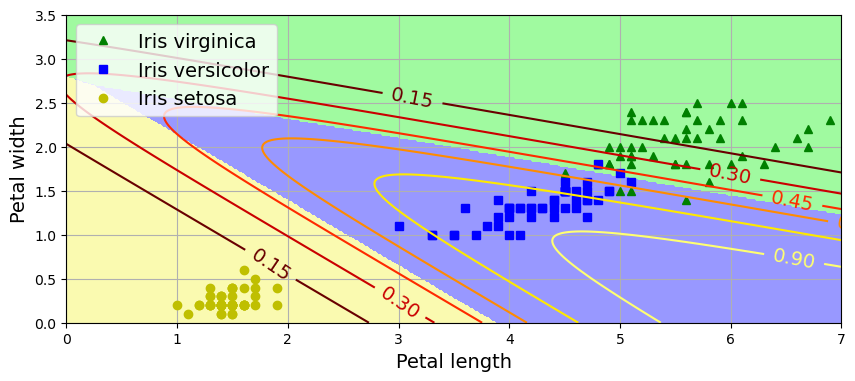

In [63]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

And now let's measure the final model's accuracy on the test set:

In [64]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

Well we get even better performance on the test set. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.